<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/054_FFT_Signal_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📡 FFT: Jak zamienić Czas na Częstotliwość?

Większość danych, które widzisz (ceny, dźwięk), jest w **Domenie Czasu** (oś X to sekundy/dni).
FFT przenosi nas do **Domeny Częstotliwości** (oś X to Hz).

**Idea Fouriera:**
Każdy, nawet najbardziej skomplikowany wykres, można zbudować, dodając do siebie proste sinusoidy.

**Przykład praktyczny:**
Masz nagranie rozmowy, w tle słychać pisk klimatyzacji.
*   W czasie: Widzisz zaszumioną falę. Trudno to naprawić.
*   W częstotliwości: Widzisz wyraźny "pik" na 5000 Hz (to ten pisk).
*   Akcja: Zerujesz ten pik i wracasz do czasu (Inverse FFT). Szum znika.

Zrobimy to teraz w kodzie.

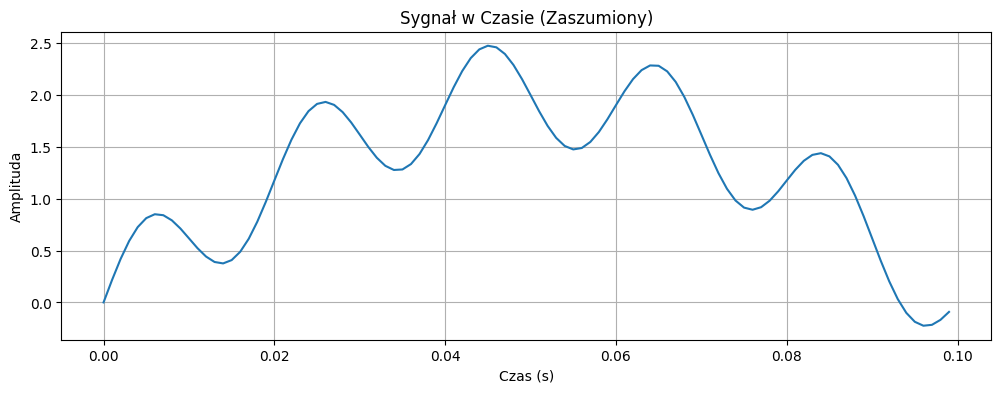

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft

# 1. GENERUJEMY SYGNAŁ (Koktajl dźwiękowy)
# Ustawienia
SAMPLE_RATE = 1000  # Próbkowanie (ile punktów na sekundę)
DURATION = 2        # Sekundy

N = SAMPLE_RATE * DURATION # Liczba wszystkich punktów
x = np.linspace(0, DURATION, N, endpoint=False) # Oś czasu

# Składniki sygnału
# 1. Czysty, niski sygnał (np. głos) - 5 Hz
signal_clean = 2.0 * np.sin(2 * np.pi * 5 * x)

# 2. Szum (wysoki pisk) - 50 Hz
noise = 0.5 * np.sin(2 * np.pi * 50 * x)

# 3. Mieszamy (To słyszy mikrofon)
signal_dirty = signal_clean + noise

# Wizualizacja (tylko kawałek, żeby było widać kształt)
plt.figure(figsize=(12, 4))
plt.plot(x[:100], signal_dirty[:100])
plt.title("Sygnał w Czasie (Zaszumiony)")
plt.xlabel("Czas (s)")
plt.ylabel("Amplituda")
plt.grid()
plt.show()

## Krok 1: FFT (Rozszczepienie światła)

Teraz użyjemy `fft`.
Zwraca ona liczby zespolone (Complex Numbers). Nas interesuje ich **Moduł (Abs)**, czyli siła danej częstotliwości.

Oś X musimy przeliczyć sami (funkcja `fftfreq`), żeby wiedzieć, który słupek to ile Hz.

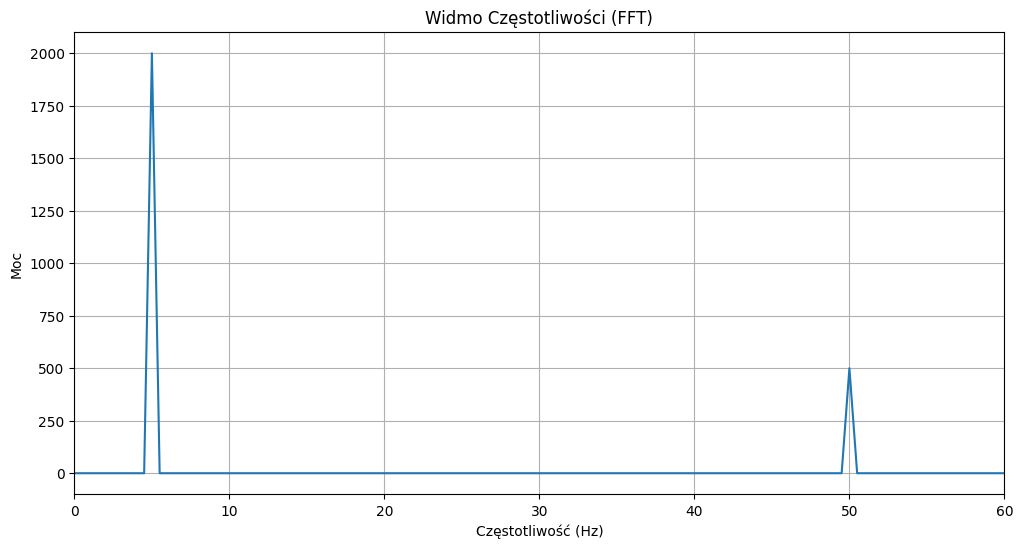

ANALIZA:
Widzisz dwa piki?
Jeden gigantyczny na 5 Hz (Nasz sygnał).
Jeden mniejszy na 50 Hz (Szum).
FFT idealnie rozpoznało składniki koktajlu!


In [2]:
# 1. Liczymy FFT
yf = fft(signal_dirty)

# 2. Generujemy oś częstotliwości (Oś X)
xf = fftfreq(N, 1 / SAMPLE_RATE)

# 3. Bierzemy tylko dodatnią połowę (FFT jest symetryczne, druga połowa to lustrzane odbicie)
# Interesuje nas zakres od 0 do N//2
n_half = N // 2

plt.figure(figsize=(12, 6))
plt.plot(xf[:n_half], np.abs(yf[:n_half])) # abs() jest kluczowe!
plt.title("Widmo Częstotliwości (FFT)")
plt.xlabel("Częstotliwość (Hz)")
plt.ylabel("Moc")
plt.grid()
plt.xlim(0, 60) # Zbliżenie na interesujący nas zakres
plt.show()

print("ANALIZA:")
print("Widzisz dwa piki?")
print("Jeden gigantyczny na 5 Hz (Nasz sygnał).")
print("Jeden mniejszy na 50 Hz (Szum).")
print("FFT idealnie rozpoznało składniki koktajlu!")

## Krok 2: Filtrowanie (Wycinamy Szum)

Skoro wiemy, że 50 Hz to szum, możemy to usunąć.
Działamy jak chirurg:
1.  Bierzemy wynik FFT.
2.  Wszystkie wartości powyżej np. 20 Hz ustawiamy na ZERO.
3.  Robimy **Odwrotną Transformatę (Inverse FFT)**, żeby wrócić do dźwięku.

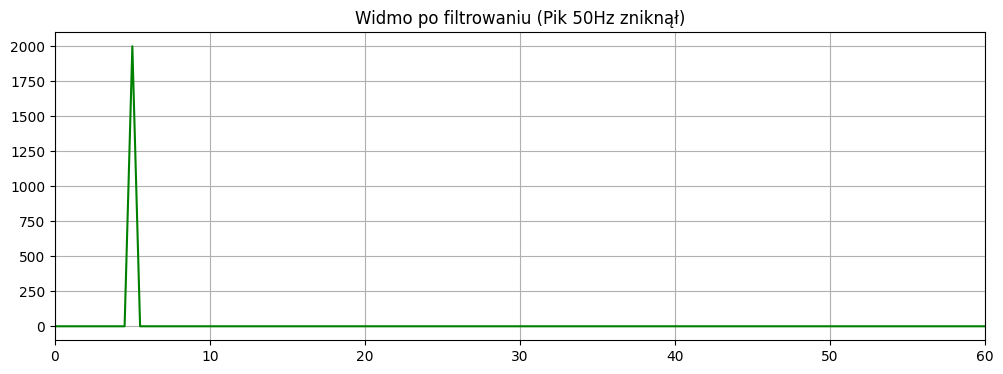

In [3]:
# Kopia wyniku FFT
yf_clean = yf.copy()

# Filtr: Wyzeruj wszystko, co ma częstotliwość większą niż 20 Hz
# (Musimy to zrobić dla obu połówek - dodatniej i ujemnej)
indices = np.abs(xf) > 20
yf_clean[indices] = 0

# Wizualizacja po cięciu
plt.figure(figsize=(12, 4))
plt.plot(xf[:n_half], np.abs(yf_clean[:n_half]), color='green')
plt.title("Widmo po filtrowaniu (Pik 50Hz zniknął)")
plt.xlim(0, 60)
plt.grid()
plt.show()

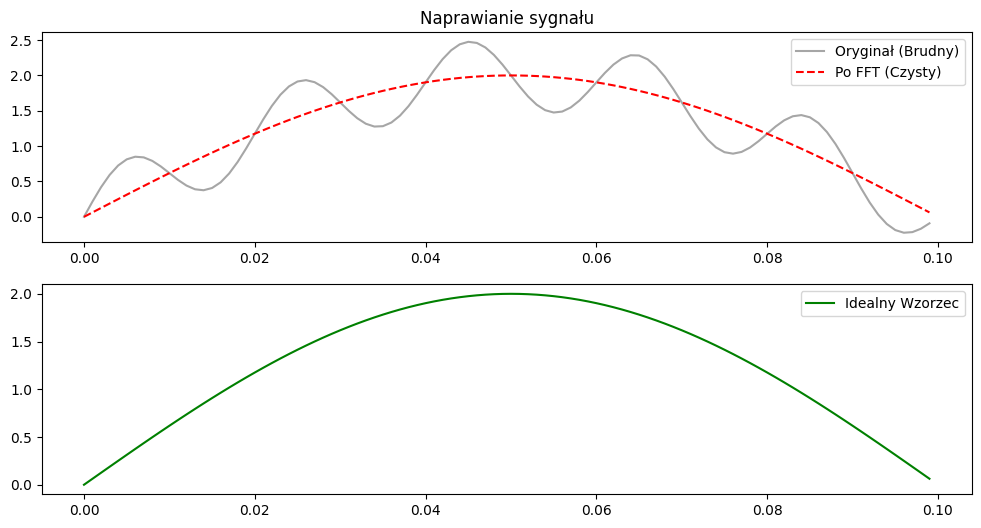

Sukces! Czerwona linia przerywana (odzyskana z FFT) pokrywa się z zielonym oryginałem.


In [4]:
# Powrót do Czasu (iFFT)
new_signal = ifft(yf_clean)

# Wizualizacja porównawcza
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(x[:100], signal_dirty[:100], label='Oryginał (Brudny)', color='gray', alpha=0.7)
plt.plot(x[:100], np.real(new_signal[:100]), label='Po FFT (Czysty)', color='red', linestyle='--')
plt.legend()
plt.title("Naprawianie sygnału")

plt.subplot(2, 1, 2)
plt.plot(x[:100], signal_clean[:100], label='Idealny Wzorzec', color='green')
plt.legend()
plt.show()

print("Sukces! Czerwona linia przerywana (odzyskana z FFT) pokrywa się z zielonym oryginałem.")

## 🧠 Podsumowanie: Jak słyszy AI?

Dokładnie tak działa kompresja **MP3** (wyrzuca częstotliwości, których ucho nie słyszy) i odszumianie w słuchawkach.

W Deep Learningu (Audio), zamiast wrzucać do sieci surową falę (która jest długa i trudna), wrzucamy **Spektrogram**.
Spektrogram to obrazek, gdzie:
*   Oś X: Czas.
*   Oś Y: Częstotliwość (z FFT).
*   Kolor: Moc.

Dzięki temu sieci CNN (te od obrazków) mogą "widzieć" dźwięk i rozpoznawać słowa ("Hey Siri").